In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

- 심사 기준     : **RMSLE(Root Mean Squared Logarithmic Error)** of ECLO  
- ECLO         : 인명피해 심각도(Equivalent Casualty Loss Only)  
- **ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1**
- 다른 유형의 사고들을 부상자 기준으로 환산하여 사고의 심각 정도와 위험도를 표현하는 방법  
- 부상자       : 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우   
- Public Score : 전체 테스트 데이터 중 30%  
- Private Score: 전체 테스트 데이터 중 70%  

In [27]:
train = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/train.csv')
test = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/test.csv')
sample = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/sample_submission.csv')
accident = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/external_open/countrywide_accident.csv')
cctv = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/external_open/대구 CCTV 정보.csv', encoding='euc-kr')
light = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/external_open/대구 보안등 정보.csv', encoding='euc-kr')
kid = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/external_open/대구 어린이 보호 구역 정보.csv', encoding='euc-kr')
park = pd.read_csv('/users/jjong/desktop/vscode/Dacon_src/Daegu/external_open/대구 주차장 정보.csv', encoding='euc-kr')

In [28]:
def rmsle(y_true, y_pred):
    """
    Root Mean Squared Logarithmic Error (RMSLE) 계산
    
    Parameters:
    - y_true: 실제 값 배열
    - y_pred: 예측 값 배열
    
    Returns:
    - rmsle_score: RMSLE 점수
    """
    assert len(y_true) == len(y_pred), "입력 배열의 길이가 같아야 합니다."
    
    # 각 값에 1을 더하고 로그 취하기
    log_diff = np.log1p(y_pred) - np.log1p(y_true)
    
    # 제곱하기
    squared_log_diff = np.square(log_diff)
    
    # 평균 구하기
    mean_squared_log_diff = np.mean(squared_log_diff)
    
    # 제곱근 취하기
    rmsle_score = np.sqrt(mean_squared_log_diff)
    
    return rmsle_score

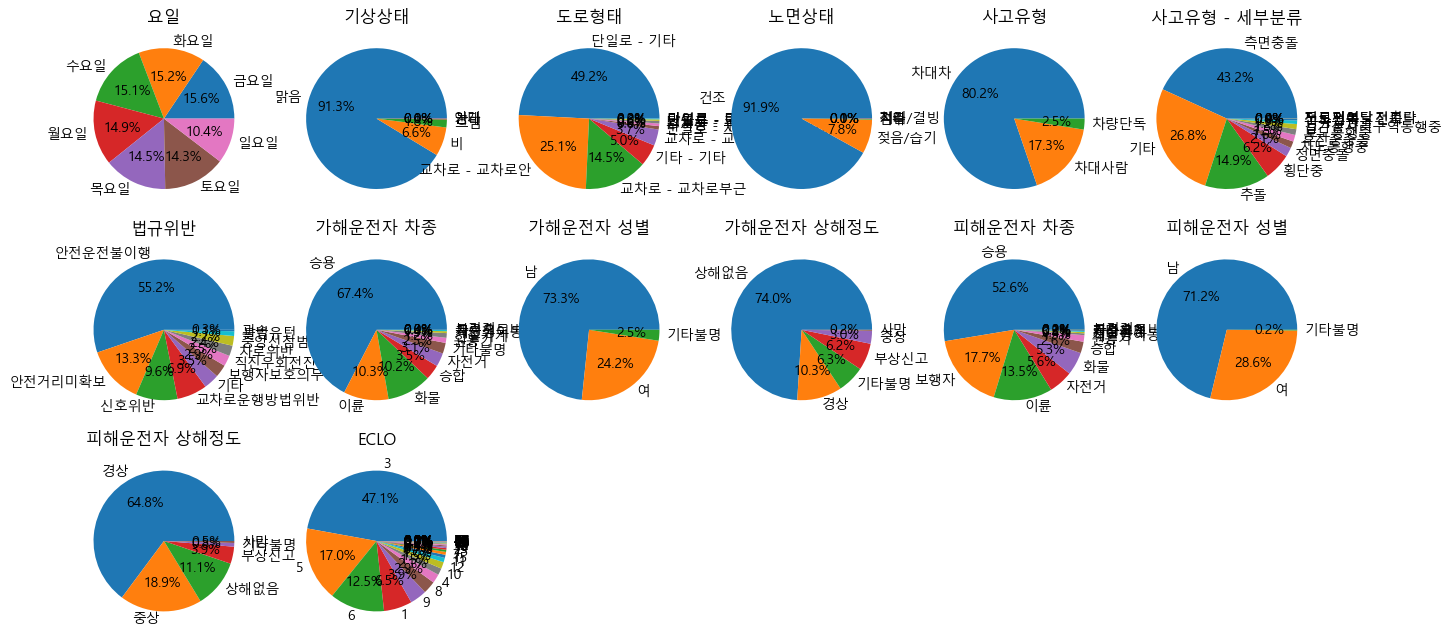

In [ ]:
plt.figure(figsize=(16,16))
for i, column in enumerate(train.columns[[2,3,5,6,7,8,9,10,11,13,14,15,17,22]]):
    plt.subplot(6,6,i+1)
    plt.pie(train[column].value_counts(), labels=train[column].value_counts().index, autopct='%1.1f%%')
    plt.title(column)
plt.show()

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA

X = train.drop(['ID', '사고일시', '시군구'], axis=1)
y = train['ECLO']
X2 = train[train['기상상태'] != '안개']
y2 = X2['ECLO']
X2 = X2[['요일','기상상태','도로형태','노면상태','사고유형']]

In [30]:
xgb = XGBRegressor()
scaler = StandardScaler()
X2 = pd.get_dummies(X2)
test_file = pd.get_dummies(test.drop(['ID', '시군구', '사고일시'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
test_file_sc = scaler.transform(test_file)

X = pd.get_dummies(X)
X = scaler.fit_transform(X)

In [31]:

X_deep_sc = X
X_deep_sc.shape
y_deep = y

# X_train_val, X_test, y_train_val, y_test = train_test_split(XD_sc, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

features_all = X
labels = y
num_test_features = test_file_sc.shape[1]

# 훈련 데이터와 테스트 데이터를 나누기
X_train, X_test, y_train, y_test = train_test_split(features_all, labels, test_size=0.2, random_state=42)

# 첫 번째 모델 훈련 (train의 모든 특성 사용)
model_step1 = RandomForestRegressor(n_estimators=500, max_depth=5)
model_step1.fit(X_train, y_train)

# 첫 번째 모델로 테스트 데이터 예측
pred_step1 = model_step1.predict(X_test).reshape(-1)

# 예측 결과를 훈련 데이터에 추가
X_train_step2 = np.concatenate((X_train, pred_step1[:, np.newaxis]), axis=1)  # 새로운 열을 추가하고 예측 결과를 삽입

# 두 번째 모델 훈련 (추가된 예측 결과를 사용)
model_step2 = XGBRegressor(colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=1.0)
model_step2.fit(X_train_step2, y_train)

# 두 번째 모델로 최종 예측
X_test_step2 = np.concatenate((X_test, pred_step1[:, np.newaxis]), axis=1)  # 새로운 열을 추가하고 예측 결과를 삽입
final_predictions = model_step2.predict(X_test_step2)

# 최종 예측 평가
rmsle = rmsle(y_test, final_predictions)
print(f'최종 모델 정확도: {rmsle}')


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 31687 and the array at index 1 has size 7922

In [38]:
def expand_features(data, num_additional_features):
    """
    특성을 늘리기 위한 함수.

    Parameters:
    - data: 기존 데이터
    - num_additional_features: 추가할 특성의 수

    Returns:
    - 늘어난 특성을 포함한 데이터
    """
    additional_features = np.zeros((len(data), num_additional_features))
    return np.concatenate((data, additional_features), axis=1)


# 테스트 데이터의 특성 수를 늘리기
test_file_sc_expanded = expand_features(test_file_sc, num_additional_features=293 - 32)

# 모델에 테스트 데이터 적용
predictions = model_step2.predict(test_file_sc_expanded)


In [40]:
predictions.shape

(10963,)

In [42]:
sample.drop('ECLO', axis=1, inplace=True)
sample['ECLO'] = predictions
sample.to_csv('submission5_rf_xgb.csv', index=False)